# Pytorch Algorithm Comparison

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Utilize GPU if available
# Set up the device for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and load the HIGGS dataset from the URL
# Load the CSV file
DIR = 'C:\\Programming\\Mafijski Praktikum\\#12 - Higgs\\'
data_path = DIR+'higgs\\HIGGS.csv.gz'
gz = data_path  # Path to the downloaded file (you can manually download it from http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz)
"""
# Load the dataset using pandas
print("Loading dataset...")
data = pd.read_csv(gz, compression='gzip', header=None)
print("Dataset loaded!")
# Print the shape of the data
print(f"Full dataset shape: {data.shape}")

# Separate features and labels
X = data.iloc[:, 1:].values  # All features (the first column is the label)
y = data.iloc[:, 0].values   # Labels (0 or 1)

"""

# Load the dataset in chunks and select a random batch
def load_batch(data_path, batch_size, chunk_size=10000):
    print(f"Loading a batch of {batch_size} samples...")

    # Initialize containers for the selected batch
    X_batch = []
    y_batch = []
    total_loaded = 0

    # Load the dataset in chunks
    for chunk in pd.read_csv(data_path, compression='gzip', header=None, chunksize=chunk_size):
        # Shuffle the chunk
        chunk = chunk.sample(frac=1).reset_index(drop=True)

        # Separate features and labels
        X_chunk = chunk.iloc[:, 1:].values  # Features
        y_chunk = chunk.iloc[:, 0].values   # Labels

        # Determine how much more data we need to fill the batch
        remaining = batch_size - total_loaded

        if len(X_chunk) >= remaining:
            # If the current chunk has more than enough data to complete the batch
            X_batch.append(X_chunk[:remaining])
            y_batch.append(y_chunk[:remaining])
            break
        else:
            # If the current chunk doesn't complete the batch, add the entire chunk
            X_batch.append(X_chunk)
            y_batch.append(y_chunk)
            total_loaded += len(X_chunk)

    # Concatenate all parts of the batch
    X_batch = np.concatenate(X_batch, axis=0)
    y_batch = np.concatenate(y_batch, axis=0)

    print(f"Batch loaded: X_batch shape = {X_batch.shape}, y_batch shape = {y_batch.shape}")
    return X_batch, y_batch

# Load a batch of 10,000 or 100,000 samples
batch_size = 10000  # You can change this to 10000 if needed
X_batch, y_batch = load_batch(data_path, batch_size)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X_batch)
y = y_batch

# One-hot encode the labels (2 classes: signal/background)
#encoder = OneHotEncoder(sparse_output=False)
#y = encoder.fit_transform(y.reshape(-1, 1))
# 
# # Split the dataset into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the datasets into PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)

# Create TensorDatasets for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Define DataLoader for batching and shuffling
BATCH_SIZE = 1024
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Training data shape: ", X_train_tensor.shape)
print("Validation data shape: ", X_val_tensor.shape)

Loading a batch of 10000 samples...
Batch loaded: X_batch shape = (10000, 28), y_batch shape = (10000,)
Training data shape:  torch.Size([8000, 28])
Validation data shape:  torch.Size([2000, 28])


# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Train function
def train(model, train_loader, val_loader, criterion=None, optimizer=None, epochs=30, patience=5):
    if criterion == None:
        criterion = nn.CrossEntropyLoss()  # No change here, using CrossEntropyLoss
    if optimizer == None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

    early_stopping = EarlyStopping(patience=patience)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            train_correct += (pred == target).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        
        val_loss, val_acc = validate(model, val_loader, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss*100:.4f}, Val Loss: {val_loss*100:.4f}, Train Acc: {train_acc*100:.4f}, Val Acc: {val_acc*100:.4f}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            val_correct += (pred == target).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)
    return val_loss, val_acc


In [106]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Sample MLP models of different sizes
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn=nn.ReLU()):
        super(MLP, self).__init__()
        layers = []
        last_size = input_size
        for hidden in hidden_layers:
            layers.append(nn.Linear(last_size, hidden))
            layers.append(activation_fn)
            last_size = hidden
        layers.append(nn.Linear(last_size, 2))  # Output layer: 2 classes
        layers.append(nn.Softmax(dim=1))  # Output in the range of [0, 1]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Train function
def train(model, train_loader, val_loader, criterion=None, optimizer=None, epochs=30, patience=5):
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    early_stopping = EarlyStopping(patience=patience)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "val_auc": [], "val_fpr": [], "val_tpr": []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            train_correct += (pred == target).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        
        val_loss, val_acc, fpr, tpr, auc = validate(model, val_loader, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(auc)
        history["val_fpr"].append(fpr)
        history["val_tpr"].append(tpr)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%, Val AUC: {auc:.4f}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return history

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    val_correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Calculate loss
            loss = criterion(output, target)
            val_loss += loss.item()

            # Collect true labels and predicted probabilities
            y_true.extend(target.cpu().numpy())
            if output.shape[1] == 1:  # Single output for sigmoid
                y_pred.extend(torch.sigmoid(output).cpu().numpy())
            else:  # Softmax for two classes
                y_pred.extend(output[:, 1].cpu().numpy())

            # Calculate accuracy
            pred = torch.argmax(output, dim=1)
            val_correct += (pred == target).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / len(val_loader.dataset)

    # Calculate ROC and AUC
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return val_loss, val_acc, fpr, tpr, auc


In [107]:
# Plot training and validation metrics (loss, accuracy, ROC curve)
def plot_metrics(histories, labels):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history["train_loss"], label=f'Train Loss - {label}')
        plt.plot(history["val_loss"], label=f'Val Loss - {label}', linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history["train_acc"], label=f'Train Acc - {label}')
        plt.plot(history["val_acc"], label=f'Val Acc - {label}', linestyle='--')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.savefig(f'metrics{str(labels[0])}2.png')
    plt.show()

# ROC Curve
def plot_roc_curves(models, loaders, labels):
    plt.figure(figsize=(8, 8))

    for model, (train_loader, val_loader), label in zip(models, loaders, labels):
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                y_true.extend(target.cpu().numpy())
                y_pred.extend(output[:, 1].cpu().numpy())  # Probabilities for class 1

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'{label} - AUC: {auc:.4f}')

    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.savefig(f'roc_curves{str(labels)}2.png')
    plt.show()



In [108]:
# Load Higgs dataset (assuming dataset already loaded into train and validation sets)
# Assume X_train, y_train, X_val, y_val are your training and validation datasets



train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 1. Model size comparison
model_sizes = {
    'Tiny': [64],
    'Small': [128, 64],
    'Medium': [256, 128, 64],
    'Large': [512, 256, 128, 64]
}

histories_size = []
for label, hidden_layers in model_sizes.items():
    model = MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=5)
    histories_size.append(history)

Epoch 1/30, Train Loss: 0.0106, Val Loss: 0.0107, Train Acc: 56.17%, Val Acc: 60.15%, Val AUC: 0.6418
Epoch 2/30, Train Loss: 0.0102, Val Loss: 0.0104, Train Acc: 62.40%, Val Acc: 63.35%, Val AUC: 0.6745
Epoch 3/30, Train Loss: 0.0100, Val Loss: 0.0103, Train Acc: 64.60%, Val Acc: 64.65%, Val AUC: 0.6924
Epoch 4/30, Train Loss: 0.0098, Val Loss: 0.0102, Train Acc: 65.74%, Val Acc: 65.10%, Val AUC: 0.7037
Epoch 5/30, Train Loss: 0.0097, Val Loss: 0.0101, Train Acc: 67.17%, Val Acc: 66.30%, Val AUC: 0.7068
Epoch 6/30, Train Loss: 0.0096, Val Loss: 0.0101, Train Acc: 67.81%, Val Acc: 65.75%, Val AUC: 0.7109
Epoch 7/30, Train Loss: 0.0095, Val Loss: 0.0100, Train Acc: 68.99%, Val Acc: 65.50%, Val AUC: 0.7131
Epoch 8/30, Train Loss: 0.0094, Val Loss: 0.0100, Train Acc: 69.35%, Val Acc: 66.05%, Val AUC: 0.7146
Epoch 9/30, Train Loss: 0.0094, Val Loss: 0.0100, Train Acc: 70.21%, Val Acc: 66.05%, Val AUC: 0.7175
Epoch 10/30, Train Loss: 0.0093, Val Loss: 0.0099, Train Acc: 70.35%, Val Acc: 67.

In [46]:
# 2. Activation function comparison
activations = {
    'ReLU': nn.ReLU(),
    'ELU': nn.ELU(),
    'Tanh': nn.Tanh(),
    'Sigmoid': nn.Sigmoid()
}

histories_act = []
for label, activation_fn in activations.items():
    model = MLP(input_size=X_train.shape[1], hidden_layers=[128, 64], activation_fn=activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=5)
    histories_act.append(history)

Epoch 1/30, Train Loss: 0.0104, Val Loss: 0.0103, Train Acc: 59.71%, Val Acc: 62.25%, Val AUC: 0.6709
Epoch 2/30, Train Loss: 0.0098, Val Loss: 0.0102, Train Acc: 64.92%, Val Acc: 64.10%, Val AUC: 0.6901
Epoch 3/30, Train Loss: 0.0096, Val Loss: 0.0101, Train Acc: 67.46%, Val Acc: 65.20%, Val AUC: 0.7013
Epoch 4/30, Train Loss: 0.0094, Val Loss: 0.0101, Train Acc: 68.92%, Val Acc: 64.85%, Val AUC: 0.7015
Epoch 5/30, Train Loss: 0.0093, Val Loss: 0.0100, Train Acc: 70.01%, Val Acc: 65.80%, Val AUC: 0.7102
Epoch 6/30, Train Loss: 0.0092, Val Loss: 0.0100, Train Acc: 71.28%, Val Acc: 66.90%, Val AUC: 0.7111
Epoch 7/30, Train Loss: 0.0091, Val Loss: 0.0099, Train Acc: 71.60%, Val Acc: 66.70%, Val AUC: 0.7161
Epoch 8/30, Train Loss: 0.0090, Val Loss: 0.0099, Train Acc: 72.32%, Val Acc: 66.70%, Val AUC: 0.7185
Epoch 9/30, Train Loss: 0.0089, Val Loss: 0.0099, Train Acc: 73.14%, Val Acc: 67.65%, Val AUC: 0.7173
Epoch 10/30, Train Loss: 0.0088, Val Loss: 0.0099, Train Acc: 74.11%, Val Acc: 66.

In [47]:
# 3. Optimizer comparison
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'AdamMax': optim.Adamax,
    'FTLR': optim.Adagrad  # Use Adagrad for similar effect
}

histories_opt = []
for label, opt_fn in optimizers.items():
    model = MLP(input_size=X_train.shape[1], hidden_layers=[128, 64]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = opt_fn(model.parameters(), lr=0.001)
    history = train(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=5)
    histories_opt.append(history)

Epoch 1/30, Train Loss: 0.0108, Val Loss: 0.0111, Train Acc: 51.91%, Val Acc: 53.85%, Val AUC: 0.5329
Epoch 2/30, Train Loss: 0.0108, Val Loss: 0.0111, Train Acc: 52.41%, Val Acc: 54.05%, Val AUC: 0.5354
Epoch 3/30, Train Loss: 0.0108, Val Loss: 0.0111, Train Acc: 52.88%, Val Acc: 53.95%, Val AUC: 0.5381
Epoch 4/30, Train Loss: 0.0108, Val Loss: 0.0111, Train Acc: 53.11%, Val Acc: 54.10%, Val AUC: 0.5408
Epoch 5/30, Train Loss: 0.0108, Val Loss: 0.0111, Train Acc: 53.29%, Val Acc: 54.20%, Val AUC: 0.5433
Epoch 6/30, Train Loss: 0.0108, Val Loss: 0.0111, Train Acc: 53.26%, Val Acc: 54.75%, Val AUC: 0.5457
Epoch 7/30, Train Loss: 0.0108, Val Loss: 0.0110, Train Acc: 53.45%, Val Acc: 54.80%, Val AUC: 0.5483
Epoch 8/30, Train Loss: 0.0108, Val Loss: 0.0110, Train Acc: 53.77%, Val Acc: 54.75%, Val AUC: 0.5507
Epoch 9/30, Train Loss: 0.0108, Val Loss: 0.0110, Train Acc: 53.74%, Val Acc: 54.60%, Val AUC: 0.5532
Epoch 10/30, Train Loss: 0.0108, Val Loss: 0.0110, Train Acc: 53.71%, Val Acc: 54.

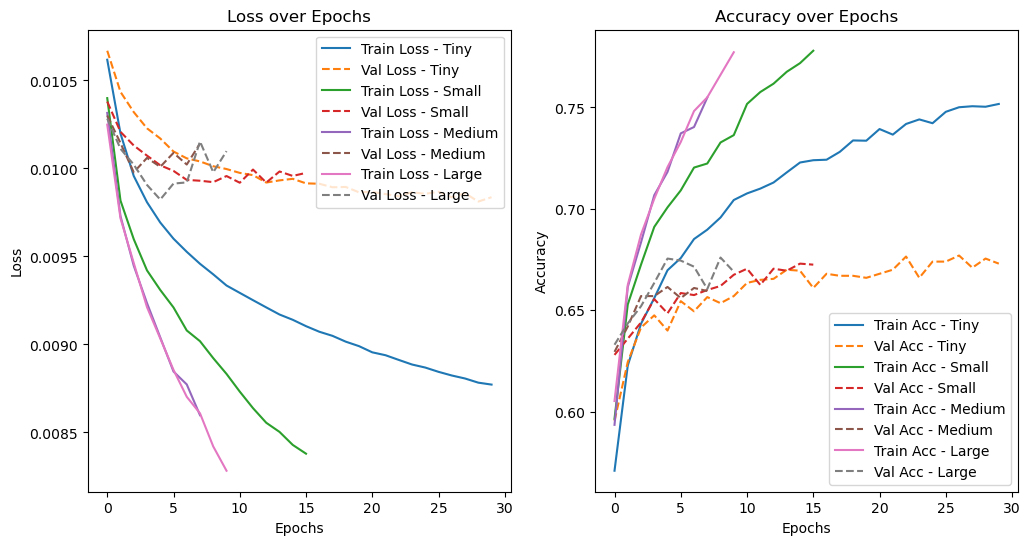

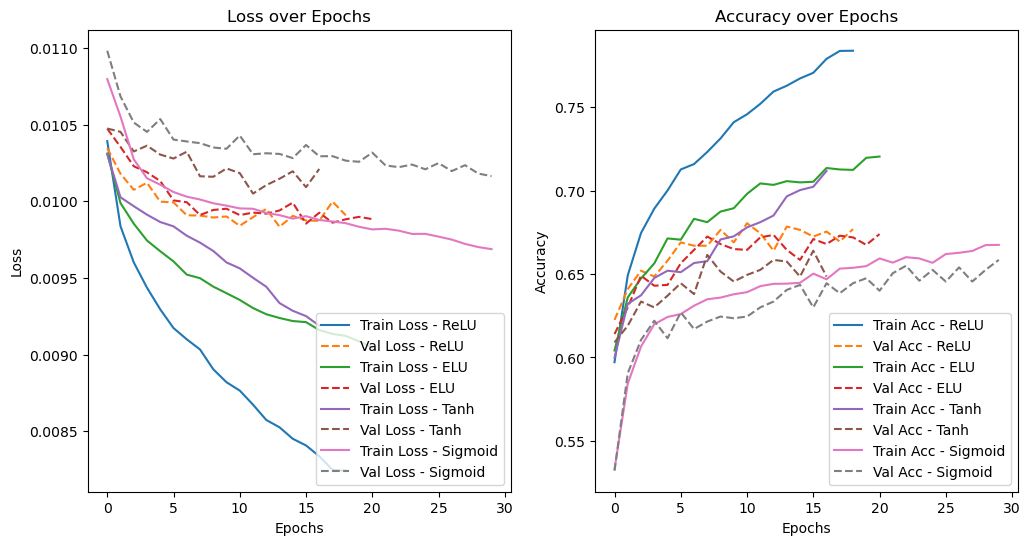

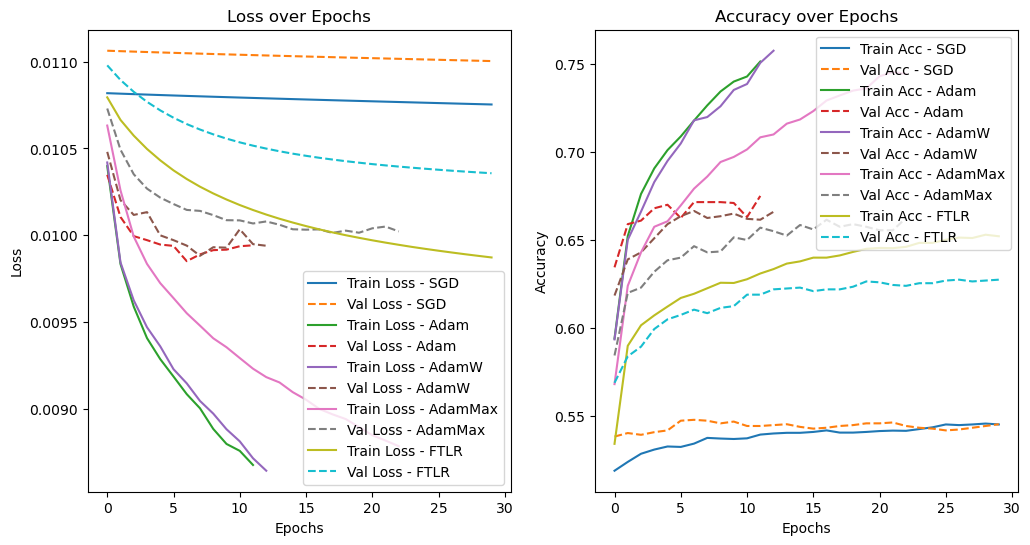

In [48]:
plot_metrics(histories_size, list(model_sizes.keys()))
plot_metrics(histories_act, list(activations.keys()))
plot_metrics(histories_opt, list(optimizers.keys()))

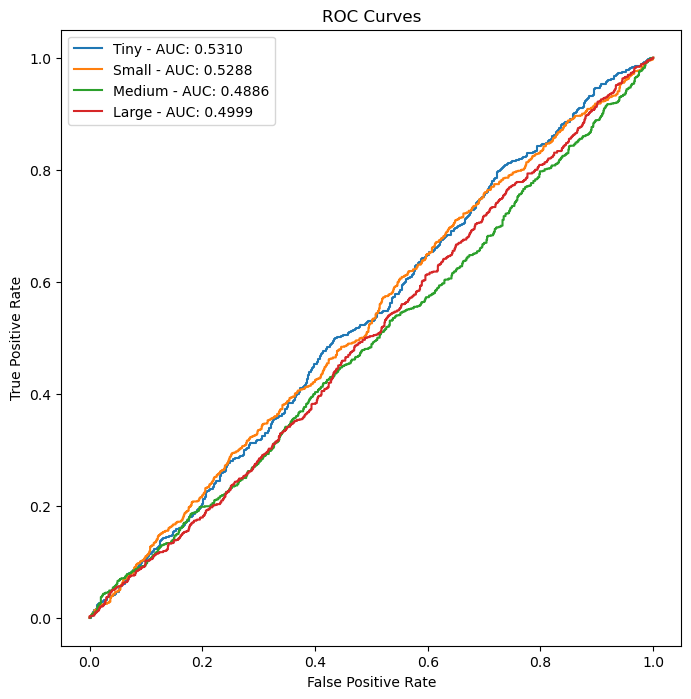

In [49]:
# Plot ROC for all models (choose one comparison set at a time)
#plot_roc_curves([MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers).to(device) for hidden_layers in model_sizes.values()], [train_loader, val_loader], list(model_sizes.keys()))

plot_roc_curves(
    [MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers).to(device) for hidden_layers in model_sizes.values()],
    [(train_loader, val_loader)] * len(model_sizes),  # Repeat the same loader pair for each model
    list(model_sizes.keys())
)

In [50]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get true labels and predicted probabilities for the validation set
all_labels = []
all_probs = []

# Set the model in evaluation mode
model.eval()

# No gradient computation needed for evaluation
with torch.no_grad():
    for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)

        # Assuming you're using softmax output for 2 classes, get class 1 probability
        probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

        # Append true labels and predicted probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities)

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc = roc_auc_score(all_labels, all_probs)

print(f"AUC: {auc}")


AUC: 0.6720395989974938


In [51]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curves(models, loaders, labels):
    plt.figure(figsize=(8, 8))

    for model, (train_loader, val_loader), label in zip(models, loaders, labels):
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                
                # Collect true labels and predicted probabilities for class 1
                y_true.extend(target.cpu().numpy())
                if output.shape[1] == 1:  # If using a single output with sigmoid
                    y_pred.extend(torch.sigmoid(output).cpu().numpy())
                else:  # If using softmax for 2 classes
                    y_pred.extend(output[:, 1].cpu().numpy())

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'{label} - AUC: {auc:.4f}')

    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    plt.savefig(f'roc_curves_{labels}.png')
    plt.show()




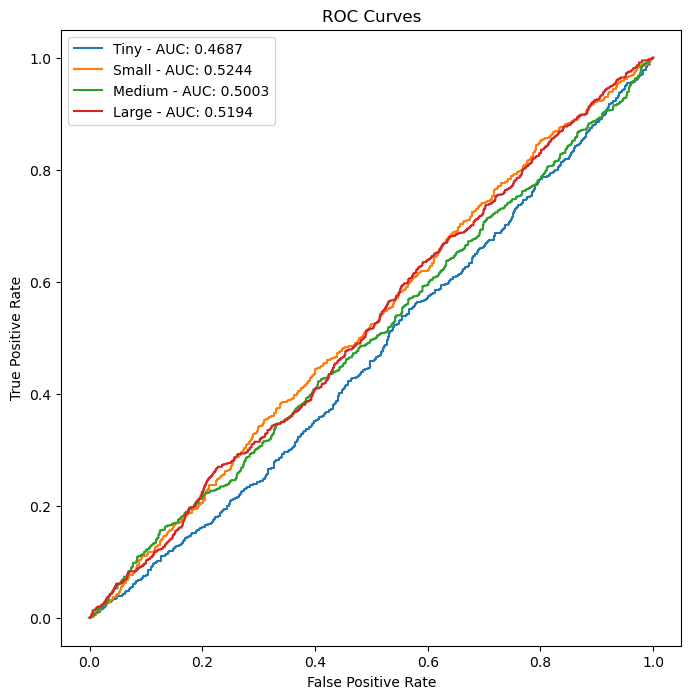

In [52]:
# Plot ROC for all models (choose one comparison set at a time)
#plot_roc_curves([MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers).to(device) for hidden_layers in model_sizes.values()], [train_loader, val_loader], list(model_sizes.keys()))
plot_roc_curves(
    [MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers).to(device) for hidden_layers in model_sizes.values()],
    [(train_loader, val_loader)] * len(model_sizes),  # Repeat the same loader pair for each model
    list(model_sizes.keys())
)

In [53]:
def plot_metrics_roc(title, histories, labels):
    plt.figure(figsize=(8, 8))
    for history, label in zip(histories, labels):
        # Get the last epoch's ROC curve values for plotting
        fpr = history["val_fpr"][-1]
        tpr = history["val_tpr"][-1]
        auc = history["val_auc"][-1]
        
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')

    plt.title(f'ROC Curves {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()

    plt.savefig(f'metrics_rocs_{labels[0]}.png')
    plt.show()

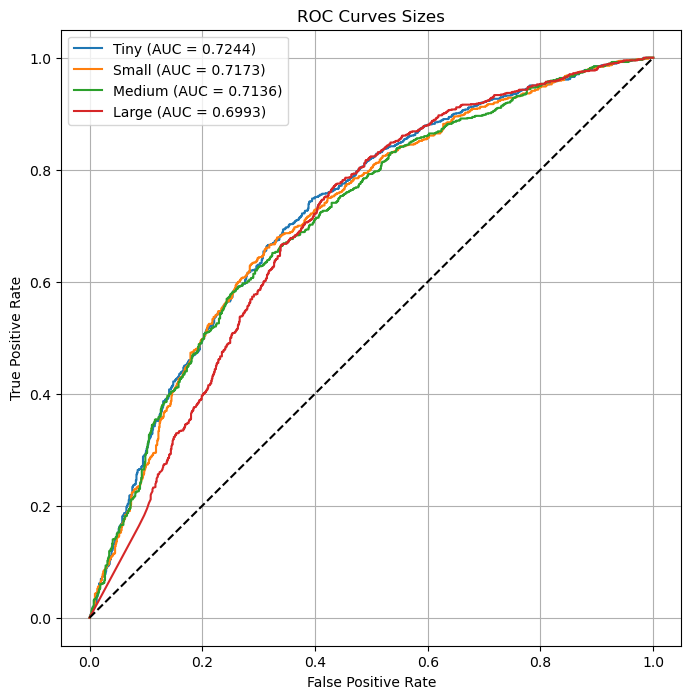

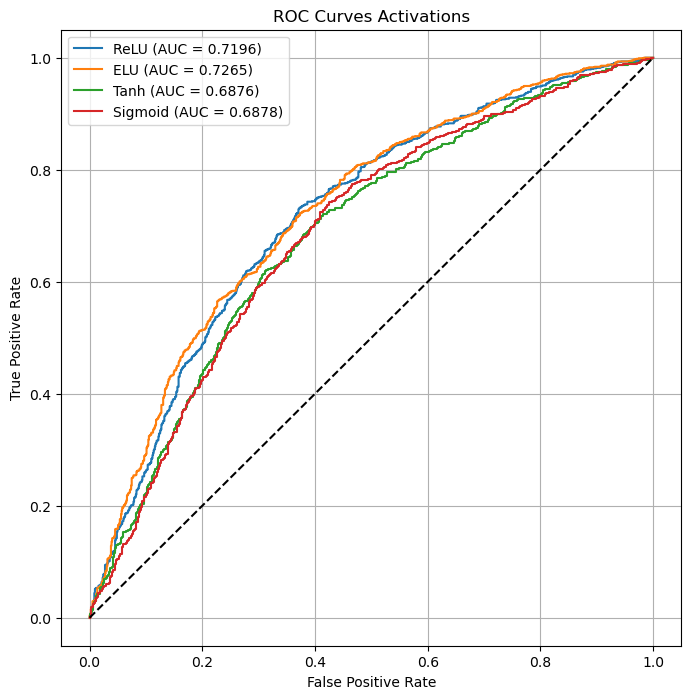

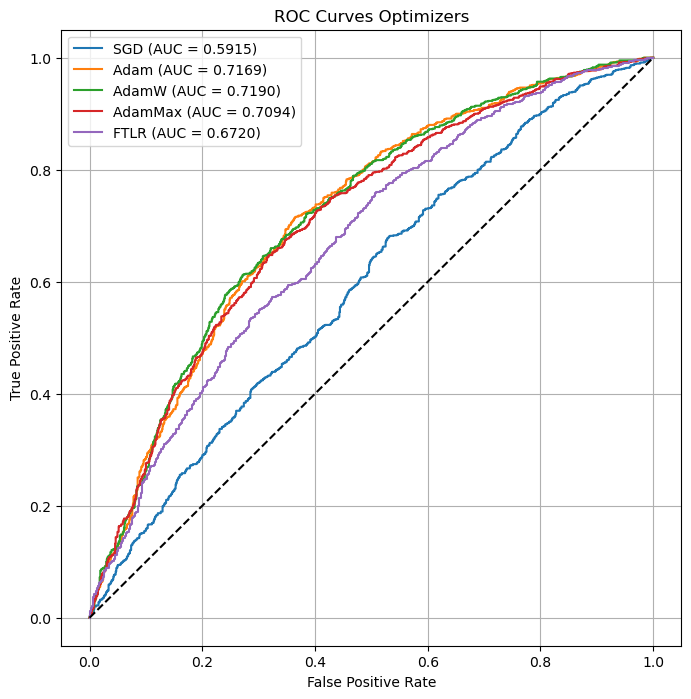

In [54]:
plot_metrics_roc("Sizes", histories_size, list(model_sizes.keys()))
plot_metrics_roc("Activations", histories_act, list(activations.keys()))
plot_metrics_roc("Optimizers", histories_opt, list(optimizers.keys()))

## Optimal

In [111]:
# Utilize GPU if available
# Set up the device for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download and load the HIGGS dataset from the URL
# Load the CSV file
DIR = 'C:\\Programming\\Mafijski Praktikum\\#12 - Higgs\\'
data_path = DIR+'higgs\\HIGGS.csv.gz'
gz = data_path  # Path to the downloaded file (you can manually download it from http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz)


# Load a batch of 10,000 or 100,000 samples
batch_size = 100000  # You can change this to 10000 if needed
X_batch, y_batch = load_batch(data_path, batch_size)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X_batch)
y = y_batch

# One-hot encode the labels (2 classes: signal/background)
#encoder = OneHotEncoder(sparse_output=False)
#y = encoder.fit_transform(y.reshape(-1, 1))
# 
# # Split the dataset into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the datasets into PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val)
y_val_tensor = torch.Tensor(y_val)

# Create TensorDatasets for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Define DataLoader for batching and shuffling
BATCH_SIZE = 1024
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Training data shape: ", X_train_tensor.shape)
print("Validation data shape: ", X_val_tensor.shape)

Loading a batch of 100000 samples...
Batch loaded: X_batch shape = (100000, 28), y_batch shape = (100000,)
Training data shape:  torch.Size([80000, 28])
Validation data shape:  torch.Size([20000, 28])


In [112]:
"""class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn=nn.ReLU()):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for out_features in hidden_layers:
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation_fn)
            in_features = out_features
        layers.append(nn.Linear(in_features, 2))  # Output layer for 2 classes
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)"""


train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# 1. Model size comparison
model_optimal = {
    'Optimal': [256, 128, 64]
    }

histories_optimal = []
# Train and evaluate models
for label, hidden_layers in model_optimal.items():
    model = MLP(input_size=X_train.shape[1], hidden_layers=hidden_layers, activation_fn=nn.ELU()).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train(model, train_loader, val_loader, criterion, optimizer, epochs=30, patience=5)
    histories_optimal.append(history)

Epoch 1/30, Train Loss: 0.0097, Val Loss: 0.0095, Train Acc: 65.96%, Val Acc: 67.80%, Val AUC: 0.7457
Epoch 2/30, Train Loss: 0.0093, Val Loss: 0.0093, Train Acc: 69.16%, Val Acc: 69.73%, Val AUC: 0.7636
Epoch 3/30, Train Loss: 0.0092, Val Loss: 0.0092, Train Acc: 70.12%, Val Acc: 70.38%, Val AUC: 0.7676
Epoch 4/30, Train Loss: 0.0092, Val Loss: 0.0092, Train Acc: 70.60%, Val Acc: 70.19%, Val AUC: 0.7711
Epoch 5/30, Train Loss: 0.0091, Val Loss: 0.0092, Train Acc: 70.98%, Val Acc: 70.31%, Val AUC: 0.7715
Epoch 6/30, Train Loss: 0.0090, Val Loss: 0.0091, Train Acc: 71.39%, Val Acc: 70.87%, Val AUC: 0.7813
Epoch 7/30, Train Loss: 0.0090, Val Loss: 0.0091, Train Acc: 71.86%, Val Acc: 70.85%, Val AUC: 0.7779
Epoch 8/30, Train Loss: 0.0089, Val Loss: 0.0090, Train Acc: 72.13%, Val Acc: 71.89%, Val AUC: 0.7892
Epoch 9/30, Train Loss: 0.0089, Val Loss: 0.0089, Train Acc: 72.50%, Val Acc: 72.34%, Val AUC: 0.7933
Epoch 10/30, Train Loss: 0.0088, Val Loss: 0.0090, Train Acc: 73.15%, Val Acc: 71.

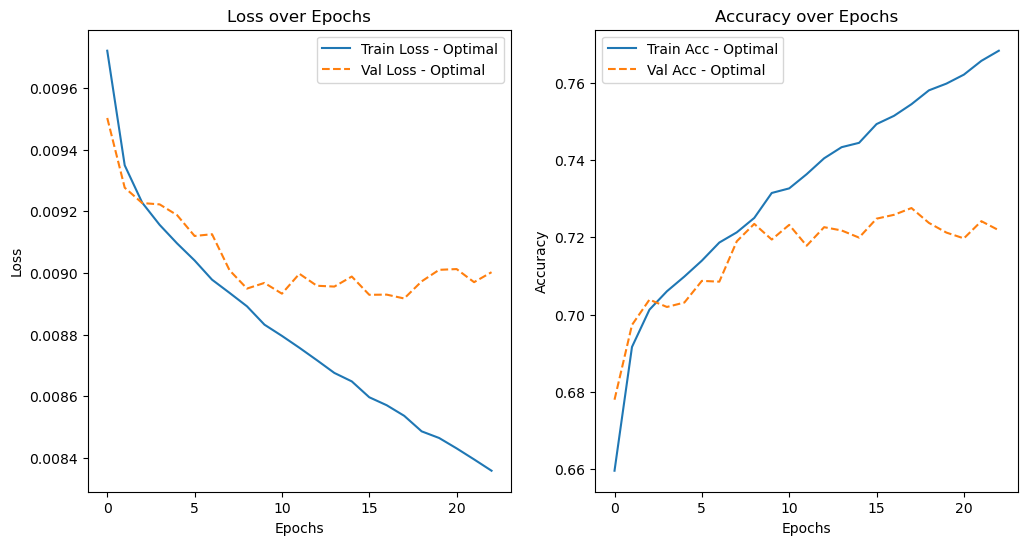

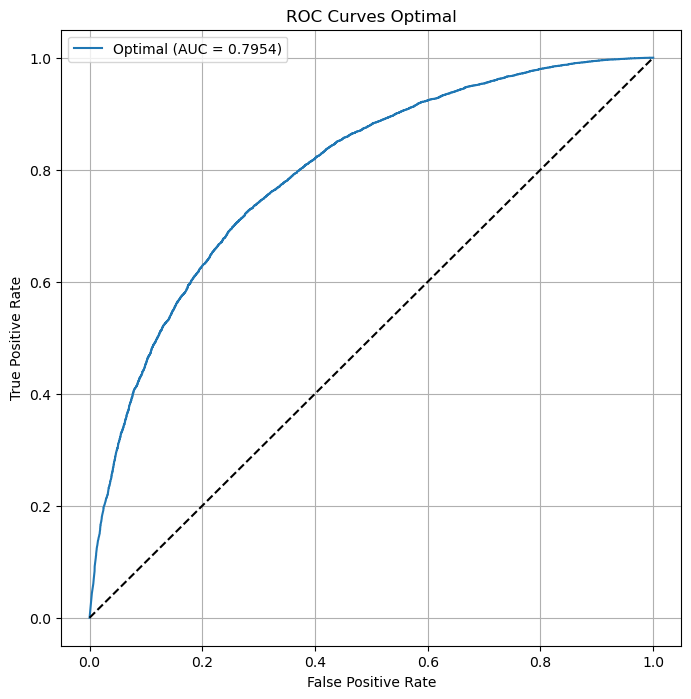

In [113]:
plot_metrics(histories_optimal, list(model_optimal.keys()))
plot_metrics_roc("Optimal", histories_optimal, list(model_optimal.keys()))

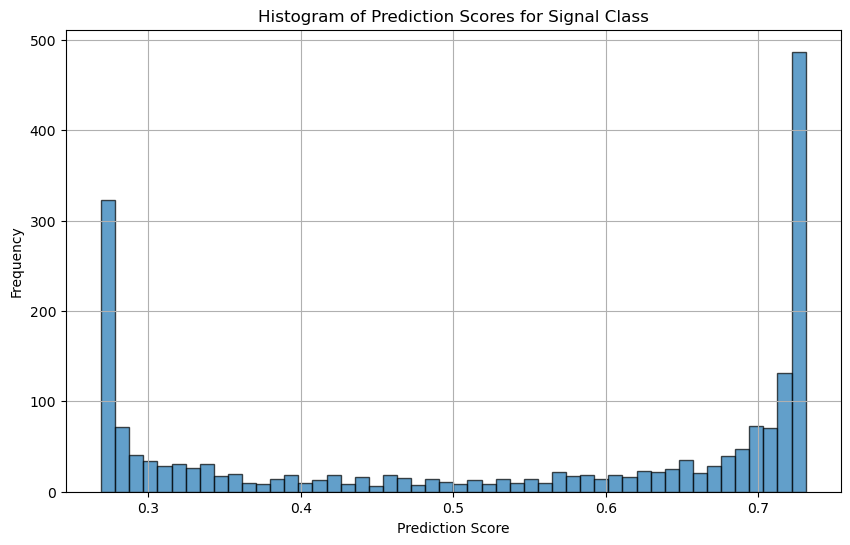

In [59]:
def plot_prediction_histogram(model, data_loader):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            scores = torch.softmax(output, dim=1)[:, 1].cpu().numpy()  # Scores for class 1 (signal)
            all_scores.extend(scores)

    plt.figure(figsize=(10, 6))
    plt.hist(all_scores, bins=50, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Prediction Scores for Signal Class')
    plt.xlabel('Prediction Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot histogram for validation data
plot_prediction_histogram(model, val_loader)

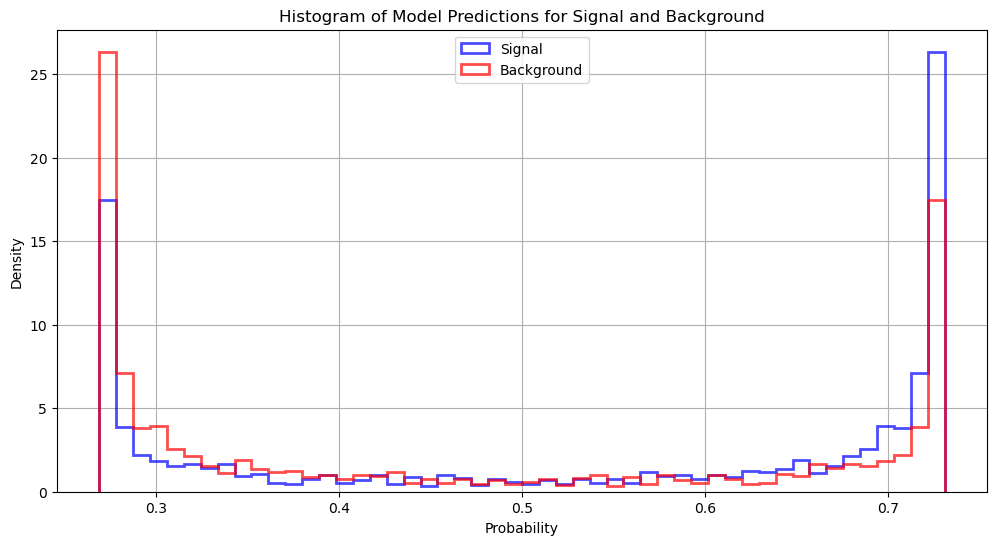

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_prediction_histogram(model, data_loader):
    """
    Plots histograms of the model's predicted probabilities for each class label (Signal and Background).
    
    Args:
        model (nn.Module): The trained PyTorch model.
        data_loader (torch.utils.data.DataLoader): DataLoader for validation or test data.
    """
    model.eval()
    y_pred_sig = []
    y_pred_bac = []

    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            scores = torch.softmax(output, dim=1).cpu().numpy()  # Probabilities for both classes
            y_pred_sig.extend(scores[:, 1])  # Probabilities for signal class
            y_pred_bac.extend(scores[:, 0])  # Probabilities for background class

    plt.figure(figsize=(12, 6))

    # Histogram for Signal class probabilities
    plt.hist(y_pred_sig, bins=50, density=True, histtype='step', color='blue', alpha=0.7, linewidth=2, label='Signal')

    # Histogram for Background class probabilities
    plt.hist(y_pred_bac, bins=50, density=True, histtype='step', color='red', alpha=0.7, linewidth=2, label='Background')

    # Adding titles and labels
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Histogram of Model Predictions for Signal and Background')
    plt.legend()
    
    plt.grid(True)
    plt.show()

# Call the function with your model and validation data loader
plot_prediction_histogram(model, val_loader)
